In [1]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [2]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [3]:
import seaborn as sns

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [5]:
df = pd.read_csv("../data/raw/hiv_cdhit_filtered.csv")

In [6]:
df

,Sequence,MIC,pIC50
0,ACWAAGIKQEF,333.000,8.007368
1,ACWGAGIKQEF,333.000,8.007368
2,ACWWAGIKAEF,333.000,8.007368
3,ACWWAGIKQAF,333.000,8.007368
4,ACWWAGIRQEF,333.000,8.007368
...,...,...,...
148,VWGIKQLQARILAVERYLKDQQLLGIWG,0.020,17.727534
149,MTWMEWDREINNYTSLIHSLIEESQNQQEKNEQELLEL,0.008,18.643824
150,MTWEAWDRAIAEYAARIEALIRAAQEQQEKNEAALREL,0.007,18.777356
151,TTWEEWDREINEYTSRIESLIRESQEQQEKNEQELREL,0.005,19.113828


In [54]:
size = len(df['MIC'])-1
df['PL'] = df['MIC'].rank(method='min').apply(lambda x: (x)/size)

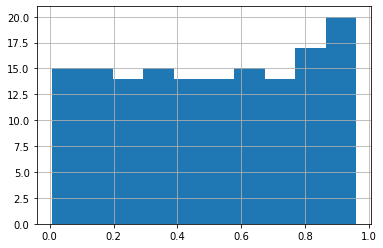

In [55]:
df['PL'].hist()

In [20]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [21]:
aa_freq = reduce_by_kmer_frequency(df)

In [22]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 153/153 [00:00<00:00, 1163.45sequence/s]


In [23]:
physicochemical_prop = get_physicochemical_properties(df)

In [24]:
X = pd.concat([aa_freq, avg_protvec, physicochemical_prop[['helix','turn','sheet']]], axis=1)

In [56]:
y = df[['PL', 'MIC']]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
y_train_pl, y_train_mic = y_train['PL'], y_train['MIC']
y_test_pl, y_test_mic = y_test['PL'], y_test['MIC']

In [59]:
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut

In [60]:
def multi_objective_score(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    std_diff = abs(np.std(y_pred) - np.std(y_true))
    return mape + 10*std_diff
multi_objective_scorer = make_scorer(multi_objective_score, greater_is_better=False)

In [61]:
param_grid = {
    'C':[0.001,0.01,0.1,1,10,100,1000],
    'kernel':['rbf','poly','sigmoid','linear'],
    'degree':[1,2,3,4,5,6],
    'gamma': np.arange(0.1,1.0,0.1).round(1).tolist() + np.arange(1,11,1).round().tolist()
}
svr = SVR()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = svr, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring=multi_objective_scorer)

In [62]:
grid_search.fit(X_train, y_train_pl)

Fitting 5 folds for each of 3192 candidates, totalling 15960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 3456 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 7984 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 13824 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 15960 out of 15960 | elapsed:   26.4s finished


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'degree': [1, 2, 3, 4, 5, 6],
                         'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             scoring=make_scorer(multi_objective_score, greater_is_better=False),
             verbose=2)

In [63]:
grid_search.best_params_

{'C': 10, 'degree': 1, 'gamma': 3, 'kernel': 'poly'}

In [64]:
best_grid = grid_search.best_estimator_

In [65]:
y_pred_pl = best_grid.predict(X_test)

In [66]:
import matplotlib.pyplot as plt

(array([3., 0., 0., 3., 3., 6., 6., 3., 4., 3.]),
 array([-0.07298743,  0.0258332 ,  0.12465384,  0.22347447,  0.3222951 ,
         0.42111573,  0.51993636,  0.618757  ,  0.71757763,  0.81639826,
         0.91521889]),
 <a list of 10 Patch objects>)

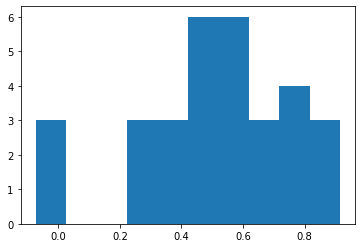

In [67]:
plt.hist(y_pred_pl)

In [68]:
mean_absolute_percentage_error(y_test_pl, y_pred_pl)

56.78731892078916

In [69]:
np.std(y_test_pl), np.std(y_pred_pl)

(0.26011179287716174, 0.2502956794128449)

In [74]:
np.std(y_pred_pl) - np.std(y_test_pl)

-0.009816113464316822

In [75]:
multi_objective_score(y_test_pl,y_pred_pl)

56.78731892078916 0.009816113464316822


56.88548005543233

In [78]:
mean_squared_error(y_test_pl,y_pred_pl)**0.5

0.2574845234679085

In [110]:
svr_params = {'C': 10, 'degree': 1, 'gamma': 3, 'kernel': 'poly'}

In [109]:
svr

SVR(C=10, degree=1, gamma=3, kernel='poly')

In [111]:
svr = SVR(**svr_params)
cv_score = cross_val_score(svr, X_train, y_train_pl, cv=5, scoring=mape_scorer)
cv_mean = cv_score.mean()
print(cv_score, cv_mean)

_ = svr.fit(X_train, y_train_pl)
y_pred = svr.predict(X_test)

print(np.std(y_test_pl), np.std(y_pred))

[ -70.49703798 -130.20452854  -74.78652528 -103.82955223 -214.78424411] -118.82037762969144
0.26011179287716174 0.2502956794128449


In [117]:
ape = 100*np.abs(y_test_pl-y_pred)/y_test_pl

In [118]:
list(zip(y_test_pl.round(4), y_pred.round(4), ape))

[(0.4474, 0.5336, 19.28546063992517),
 (0.4408, 0.5303, 20.31605871911903),
 (0.3618, 0.5089, 40.634305906403306),
 (0.25, -0.073, 129.19497117959176),
 (0.7895, 0.5219, 33.89140167638921),
 (0.2566, 0.3542, 38.05182227378668),
 (0.4934, 0.6437, 30.46544400328362),
 (0.4737, 0.7343, 55.0110457117261),
 (0.8882, 0.6524, 26.548764837166374),
 (0.9079, 0.9152, 0.8067185984855607),
 (0.8816, 0.8089, 8.244805832801724),
 (0.9145, 0.875, 4.312108484411068),
 (0.9474, 0.5901, 37.70848168319126),
 (0.7303, -0.0638, 108.73207033601935),
 (0.6645, 0.4695, 29.34209599461368),
 (0.5526, 0.4681, 15.290035521133388),
 (0.2895, 0.301, 3.9950629224825103),
 (0.1118, 0.2969, 165.44322007809717),
 (0.5789, 0.5909, 2.06149538748351),
 (0.375, 0.4841, 29.100215720704714),
 (0.5132, 0.6438, 25.459444815774667),
 (0.1908, -0.0471, 124.69408684450003),
 (0.7895, 0.753, 4.616652133464091),
 (0.5724, 0.353, 38.33466860677208),
 (0.6447, 0.8604, 33.44424513600318),
 (0.7895, 0.5078, 35.68469647893875),
 (0.8355

In [108]:
svr_pl_mic_params = {'C': 1000, 'degree': 1, 'gamma': 10, 'kernel': 'rbf'}
svr_pl_mic = SVR(**svr_pl_mic_params)

In [115]:
svr_pl_mic.fit(y_train_pl.values.reshape(122, -1), y_train_mic)

SVR(C=1000, degree=1, gamma=10)

In [125]:
y_pred_mic = svr_pl_mic.predict(y_pred.reshape(y_pred.shape[0], -1))

In [83]:
y_test_mic

84      11.000
86      10.810
97       6.000
115      2.000
29     100.000
114      2.020
78      12.720
81      11.400
18     142.000
15     187.000
19     136.000
12     200.000
9      250.000
42      54.400
51      40.000
69      23.460
109      3.050
136      0.253
65      29.500
96       6.900
75      16.000
123      1.000
31     100.000
66      28.600
55      35.200
30     100.000
26     110.000
131      0.580
135      0.263
36      67.600
113      2.100
Name: MIC, dtype: float64

In [126]:
list(zip(y_test_pl, y_pred, y_test_mic, y_pred_mic))

[(0.4473684210526316, 0.5336454818101916, 11.0, 19.79988294528067),
 (0.4407894736842105, 0.5303405219855905, 10.81, 19.337369854099165),
 (0.3618421052631579, 0.5088741332139594, 6.0, 16.52927464754424),
 (0.25, -0.07298742794897939, 2.0, 5.014844653892027),
 (0.7894736842105263, 0.5219099867653484, 100.0, 18.19268018942529),
 (0.2565789473684211, 0.3542119124130053, 2.02, 5.657180182411764),
 (0.4934210526315789, 0.6437439671214652, 12.72, 37.18738551223987),
 (0.47368421052631576, 0.7342628481081762, 11.4, 54.35889165817218),
 (0.8881578947368421, 0.6523629438804303, 142.0, 38.55302117581044),
 (0.9078947368421053, 0.9152188925388821, 187.0, 234.3047680073953),
 (0.881578947368421, 0.8088944748950374, 136.0, 90.38401921201275),
 (0.9144736842105263, 0.8750405868859777, 200.0, 164.38559151172677),
 (0.9473684210526315, 0.5901301735276617, 250.0, 28.542780358183563),
 (0.7302631578947368, -0.06376709258540447, 54.4, 3.955009355987329),
 (0.6644736842105263, 0.46950317793052754, 40.0, 

In [128]:
loo = LeaveOneOut()

from tqdm import tqdm

result_df = pd.DataFrame(columns = list(df_hiv_cdhit_filtered.columns)+["y_pred_pmic", "y_pred_mic", "ape_pmic", "ape_mic"])
for train_index, test_index in tqdm(loo.split(X)):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
    y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']
    knn = KNeighborsRegressor(**grid_search.best_params_)
    _ = knn.fit(X_train, y_train_pmic)
    y_pred_pmic = knn.predict(X_test)
    y_pred_mic = np.exp(-y_pred_pmic)/1e-6
    ape = 100*np.abs(y_test_pmic-y_pred_pmic)/y_test_pmic
    ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic
    df_val = df_hiv_cdhit_filtered.iloc[test_index,:].values[0].tolist()
    res = np.append(df_val, [y_pred_pmic[0], y_pred_mic[0], ape.values[0], ape_mic.values[0]])
    res = pd.DataFrame([res], columns = list(df_hiv_cdhit_filtered.columns)+["y_pred_pmic", "y_pred_mic", "ape_pmic", "ape_mic"])
    result_df = result_df.append(res)
result_df = result_df[["Sequence", "pIC50", "y_pred_pmic", "ape_pmic", "MIC", "y_pred_mic", "ape_mic"]]

153it [00:01, 110.82it/s]


In [129]:
result_df#.to_csv("../results/SVM_HIV_CoV_pMIC_to_MIC_rbf_c_100_gamma_2.csv", index=False)

,Sequence,pIC50,y_pred_pmic,ape_pmic,MIC,y_pred_mic,ape_mic
0,ACWAAGIKQEF,8.00736806798383,9.03066286788145,12.779415048861052,333.0,119.68313276752599,64.05911928903123
0,ACWGAGIKQEF,8.00736806798383,9.102282061228403,13.673831200821278,333.0,111.41127082375617,66.54316191478794
0,ACWWAGIKAEF,8.00736806798383,8.487746165213096,5.999200900355521,333.0,205.97697542291095,38.145052425552265
0,ACWWAGIKQAF,8.00736806798383,8.506803586328427,6.237199465596067,333.0,202.0887528873989,39.31268682060093
0,ACWWAGIRQEF,8.00736806798383,8.539554338888953,6.646207173028357,333.0,195.5774019699292,41.26804745647771
...,...,...,...,...,...,...,...
0,VWGIKQLQARILAVERYLKDQQLLGIWG,17.72753356339242,14.104157508915907,20.43925649058609,0.02,0.749276690134296,3646.3834506714797
0,MTWMEWDREINNYTSLIHSLIEESQNQQEKNEQELLEL,18.643824295266576,14.74484059651796,20.91300388267721,0.008,0.39481813471321686,4835.22668391521
0,MTWEAWDRAIAEYAARIEALIRAAQEQQEKNEAALREL,18.7773556878911,13.067580245358851,30.40777166624316,0.006999999999999999,2.1126230194343596,30080.328849062284
0,TTWEEWDREINEYTSRIESLIRESQEQQEKNEQELREL,19.11382792451231,15.236434774143634,20.285801283144117,0.005,0.24149072409314754,4729.814481862951


In [93]:
y_train_pl.values.reshape(122, -1)

array([[0.38815789],
       [0.55921053],
       [0.86184211],
       [0.71052632],
       [0.50657895],
       [0.91447368],
       [0.125     ],
       [0.13815789],
       [0.16447368],
       [0.78947368],
       [0.58552632],
       [0.07236842],
       [0.17105263],
       [0.96052632],
       [0.78947368],
       [0.29605263],
       [0.41447368],
       [0.32236842],
       [0.90131579],
       [0.27631579],
       [0.94078947],
       [0.63157895],
       [0.01315789],
       [0.26973684],
       [0.61184211],
       [0.56578947],
       [0.34210526],
       [0.28289474],
       [0.84868421],
       [0.96052632],
       [0.71710526],
       [0.03289474],
       [0.78947368],
       [0.74342105],
       [0.38157895],
       [0.84210526],
       [0.85526316],
       [0.07894737],
       [0.75      ],
       [0.05921053],
       [0.20394737],
       [0.69736842],
       [0.04605263],
       [0.23026316],
       [0.52631579],
       [0.78947368],
       [0.39473684],
       [0.026

In [130]:
result_df['ape_pmic'].astype('float').mean()

16.33867497206926

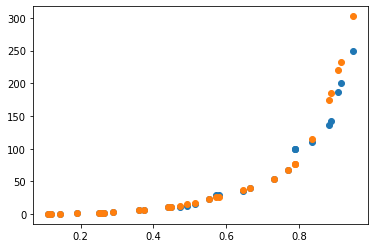

In [106]:
plt.scatter(y_test_pl,y_test_mic)
plt.scatter(y_test_pl,y_pred_pl)

In [96]:
grid_search.best_params_

{'C': 1000, 'degree': 1, 'gamma': 10, 'kernel': 'rbf'}

In [97]:
best_grid = grid_search.best_estimator_

In [100]:
y_pred_pl = best_grid.predict(y_test_pl.values.reshape(y_test.shape[0], -1))

In [101]:
mean_absolute_percentage_error(y_test_mic, y_pred_pl)

12.191398200820567

In [102]:
mean_squared_error(y_test_mic, y_pred_pl)**0.5

17.85638791044129

In [103]:
list(zip(y_test_mic, y_pred_pl))

[(11.0, 10.55279928408703),
 (10.81, 10.08336526577233),
 (6.0, 5.971539074861482),
 (2.0, 2.02130282936497),
 (100.0, 77.25170657058116),
 (2.02, 2.1987707005484367),
 (12.72, 14.736672730226417),
 (11.4, 12.737639372883734),
 (142.0, 185.14037049815903),
 (187.0, 220.1855128631019),
 (136.0, 174.47290541243672),
 (200.0, 232.8418195186542),
 (250.0, 302.5448995234245),
 (54.4, 53.28248595187537),
 (40.0, 40.48158765648941),
 (23.46, 22.589289284156393),
 (3.05, 3.220797115043922),
 (0.253, 0.31028664940885164),
 (29.5, 26.730486759313408),
 (6.9, 6.532449215485315),
 (16.0, 17.061045866911343),
 (1.0, 0.8996295005549086),
 (100.0, 77.25170657058116),
 (28.6, 25.674537801627196),
 (35.2, 37.34476077874996),
 (100.0, 77.25170657058116),
 (110.0, 114.28548161226786),
 (0.58, 0.5061615315750032),
 (0.263, 0.3497727387434111),
 (67.6, 66.98406221105193),
 (2.1, 2.3860128635998876)]

In [131]:
result_df['ape_mic'].astype('float').mean()

1906.146553954179

In [132]:
from scipy.stats import pearsonr

In [133]:
pearsonr(result_df['MIC'].astype('float'), result_df['y_pred_mic'].astype('float'))

(0.5055121692719897, 2.654597001611252e-11)

1.0

In [75]:
multi_objective_score(y_test_pl,y_pred_pl)

56.78731892078916 0.009816113464316822


56.88548005543233

In [74]:
np.std(y_pred_pl) - np.std(y_test_pl)

-0.009816113464316822